# Deep Learning Challenge
## Michelle Rohrer

### Pakete laden

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import wandb
from dotenv import load_dotenv

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from src.plots import (
    plot_class_distribution, 
    plot_sample_images,
    plot_training_curves
)
from src.model import BaselineCNN
from src.test_train import (
    overfitting_test_batch,
    train_model,
    hyperparameter_tuning_with_wandb
)
from src.evaluation import (
    evaluate_model,
    cross_validation_training
)

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")

WanDB Key erfolgreich geladen


### Daten laden und vorbereiten
Die Daten wurden von kaggle heruntergeladen (https://www.kaggle.com/datasets/msambare/fer2013)

Infos zu den Daten:

Die Daten bestehen aus 48x48 Pixel großen Graustufenbildern von Gesichtern. Die Gesichter wurden automatisch so ausgerichtet, dass sie mehr oder weniger zentriert sind und ungefähr den gleichen Bereich in jedem Bild einnehmen.

Die Aufgabe besteht darin, jedes Gesicht anhand des im Gesichtsausdruck gezeigten Gefühls einer von sieben Kategorien zuzuordnen (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). Der Trainingssatz besteht aus 28.709 Beispielen und der öffentliche Testsatz aus 3.589 Beispielen.

In [2]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

In [3]:
img_size = 48
batch_size = 64

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


#### Aufteilung in Trainings- und Validierungsdatensatz

Für die Entwicklung und Evaluation der Modelle wurde der Trainingsdatensatz in zwei separate Teilmengen aufgeteilt. Einen Trainingsdatensatz und einen Validierungsdatensatz im Verhältnis 80/20.

##### Begründung für die Aufteilung

Der Validierungsdatensatz ermöglicht es, die Leistung des Modells während des Trainingsprozesses auf bisher ungesehenen Daten zu evaluieren. Ohne diese Aufteilung bestünde die Gefahr des Overfittings, das Modell würde also die Trainingsdaten auswendig lernen, anstatt generalisierbare Muster zu erkennen. Der Validierungsdatensatz fungiert somit als unabhängige Kontrollinstanz, die frühzeitig Anzeichen von Überanpassung aufdeckt.

##### Die Wahl des 80/20-Verhältnisses

Das gewählte Verhältnis von 80% Trainings- und 20% Validierungsdaten hat sich in der Praxis bewährt und stellt einen ausgewogenen Kompromiss dar. Mit 80% der Daten für das Training steht dem Modell eine ausreichend große Datenmenge zur Verfügung, um robuste Muster zu lernen. Gleichzeitig sind 20% für die Validierung groß genug, um statistisch aussagekräftige Metriken zu liefern und die Generalisierungsfähigkeit zuverlässig zu bewerten.

### Expolorative Datenanalyse

#### Klassenverteilung

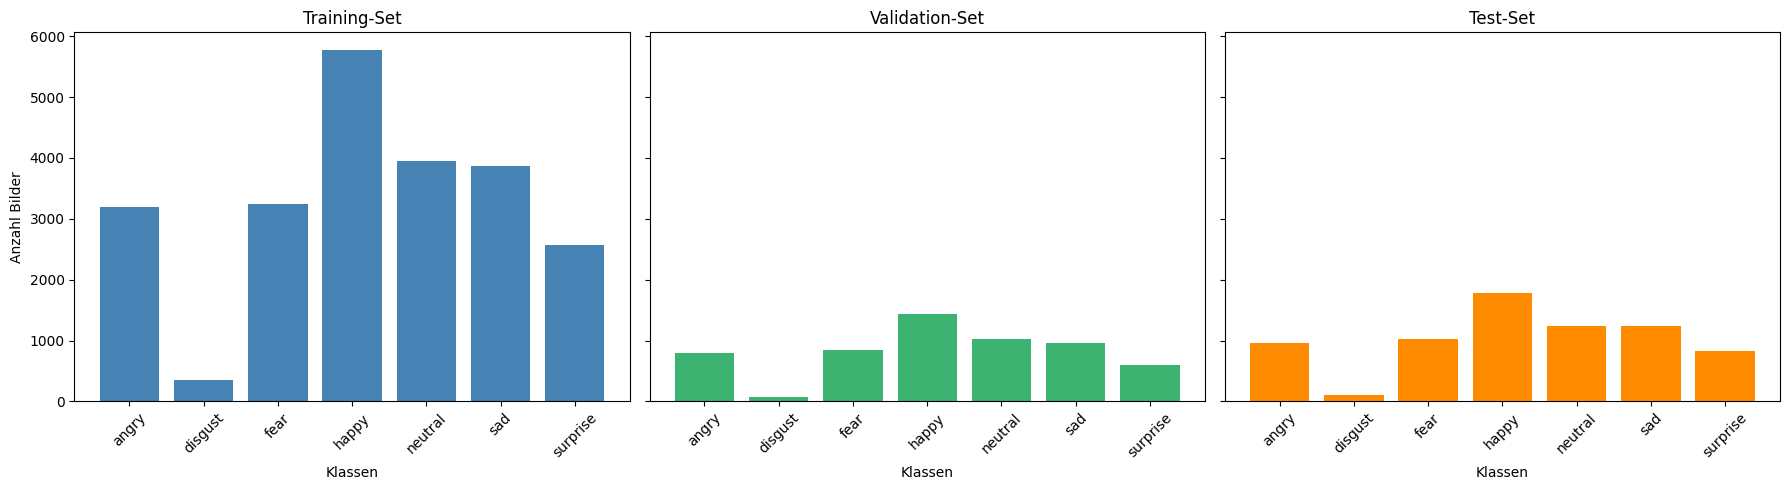

In [4]:
plot_class_distribution(train_dataset, val_dataset, test_dataset)

Die Analyse zeigt eine unbalancierte Verteilung der Klassen im Datensatz. Während *"happy"* mit Abstand am häufigsten vertreten ist, weist die Klasse *"disgust"* deutlich weniger TBeispiele auf als alle anderen Kategorien. Diese Klassenungleichgewichte können die Modellperformance beeinflussen und müssen bei der Modellevaluation berücksichtigt werden.

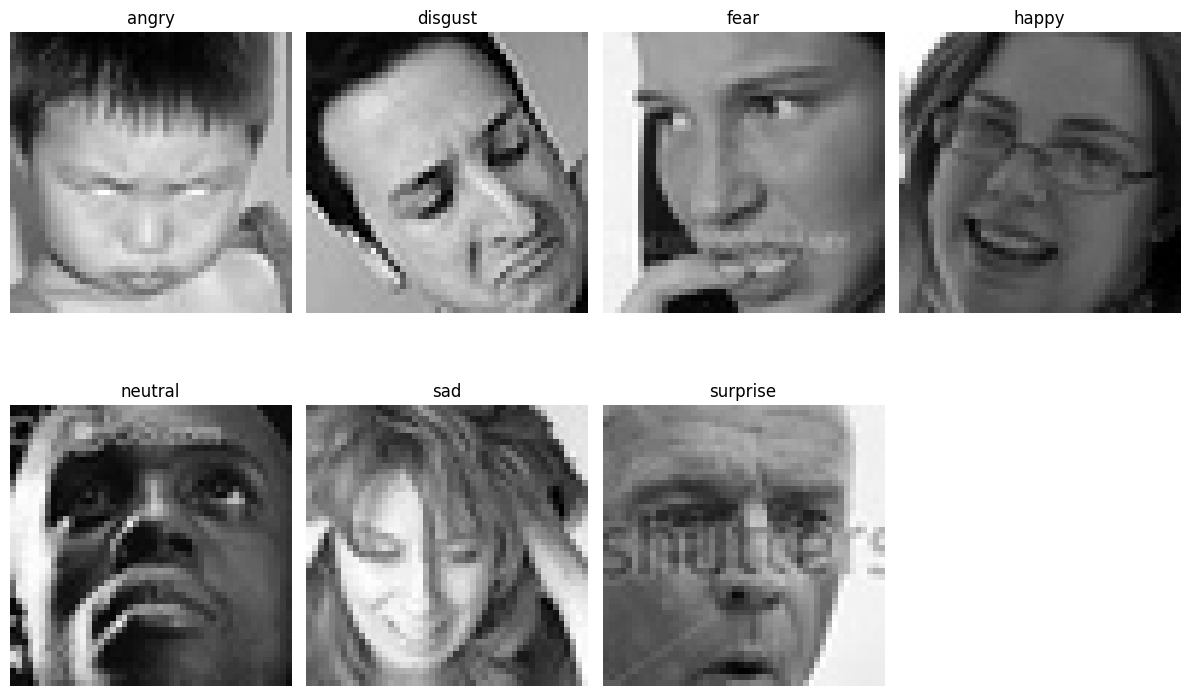

In [5]:
fig = plot_sample_images(full_train_dataset)
plt.show()

### Überblick der Metriken

Für die Evaluation des CNN-Modells zur Gesichtsausdruckserkennung werden verschiedene Metriken eingesetzt, um die Modellperformance umfassend zu bewerten:

#### 1. **Konfusionsmatrix-basierte Metriken**

**Accuracy (Genauigkeit):**
Die Accuracy misst den Anteil der korrekt klassifizierten Samples an der Gesamtanzahl. Sie gibt einen ersten Überblick über die Gesamtleistung des Modells, ist jedoch bei unbalancierten Datensätzen wie dem FER-2013-Datensatz mit Vorsicht zu interpretieren.

**Precision (Präzision):**
Die Precision für jede Klasse misst, wie viele der als Klasse X vorhergesagten Samples tatsächlich zur Klasse X gehören. Diese Metrik ist besonders wichtig, um False Positives zu identifizieren.

**Recall (Sensitivität):**
Der Recall misst, wie viele Samples einer bestimmten Klasse korrekt erkannt wurden. Diese Metrik ist entscheidend, um zu verstehen, wie gut das Modell seltene Klassen (wie "disgust") erkennt.

#### 2. **F1-Score**

Der F1-Score kombiniert Precision und Recall zu einer einzigen Metrik und stellt das harmonische Mittel dar. Er ist besonders wertvoll bei unbalancierten Datensätzen, da er sowohl False Positives als auch False Negatives berücksichtigt.

#### 3. **Top-K Accuracy**

Die Top-K Accuracy misst, ob die korrekte Klasse unter den K wahrscheinlichsten Vorhersagen liegt. Dies ist besonders relevant für Emotionserkennung, da ähnliche Emotionen (z.B. "fear" und "surprise") oft verwechselt werden können.

#### 4. **Cross-Validation**

Die Verwendung von Cross-Validation ermöglicht eine robustere Evaluation, indem das Modell auf verschiedenen Datenaufteilungen trainiert und getestet wird. Dies reduziert die Varianz der Ergebnisse und gibt eine zuverlässigere Einschätzung der Generalisierungsfähigkeit.

#### Begründung der Metrikenauswahl

Die gewählten Metriken sind speziell auf die Herausforderungen der Emotionserkennung zugeschnitten:

- **Ähnliche Emotionen:** Top-K Accuracy berücksichtigt, dass verwandte Emotionen oft verwechselt werden
- **Praktische Anwendung:** F1-Score und Precision/Recall geben Aufschluss über die praktische Brauchbarkeit des Modells
- **Robustheit:** Cross-Validation stellt sicher, dass die Ergebnisse nicht von einer zufälligen Datenaufteilung abhängen

Diese umfassende Metrikenauswahl ermöglicht es, sowohl die Gesamtleistung als auch die spezifischen Stärken und Schwächen des Modells in verschiedenen Emotionskategorien zu bewerten.

### Basismodell

#### Architektur des Baseline-CNN

Als Basismodell wird ein einfaches Convolutional Neural Network verwendet. Die Architektur besteht aus drei aufeinanderfolgenden Convolutional Blocks, gefolgt von zwei Fully Connected Layers für die Klassifikation.

**Feature Extraction:**
Der Feature-Extraction-Teil umfasst drei Convolutional Blocks mit steigender Filterzahl (16, 32, 64 Filter). Jeder Block besteht aus einer Convolutional Layer mit 3x3 Kernel-Größe und ReLU-Aktivierungsfunktion, gefolgt von einer Max-Pooling-Layer mit 2x2 Kernel.

**Klassifikation:**
Die Output-Layer verwendet keine explizite Aktivierungsfunktion, da der CrossEntropyLoss in PyTorch implizit Softmax anwendet.

**Training-Konfiguration:**
Für das Basismodell wird der Stochastic Gradient Descent (SGD) ohne Momentum als Optimizer verwendet. Die Learning Rate wird auf 0.01 gesetzt.

#### Overfitting-Test

**Zielsetzung und Begründung:**
Vor dem Training auf dem vollständigen Datensatz ist es essentiell zu verifizieren, dass das Modell überhaupt in der Lage ist zu lernen. Der Overfitting-Test ist eine Absicherung, bei dem das Modell absichtlich auf einer minimalen Datenmenge trainiert wird, um zu überprüfen, ob die Modellarchitektur, die Forward- und Backward-Passes sowie die Gradientenberechnung korrekt implementiert sind. Ein Modell, das nicht einmal wenige Beispiele auswendig lernen kann, weist auf grundlegende Implementierungsfehler hin.

**Durchführung:**
Das Modell wird auf einem einzelnen Batch (64 Samples) trainiert. Hier wird erwartet, dass das Modell nach ausreichend vielen Epochen eine Accuracy von über 99% erreicht, was bestätigt, dass es die Trainingsdaten auswendig lernen kann.

**Erwartete Ergebnisse:**
Bei einem korrekt implementierten Modell sollte der Loss kontinuierlich sinken und gegen Null konvergieren, während die Accuracy auf nahezu 100% steigt.

In [6]:
# Modell erstellen
num_classes = len(full_train_dataset.class_to_idx)
test_model = BaselineCNN(img_size=img_size, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(device)

# Summary anzeigen
summary(test_model, input_size=(1, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             160
         MaxPool2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Linear-7                   [-1, 64]         147,520
            Linear-8                    [-1, 7]             455
Total params: 171,271
Trainable params: 171,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.62
Params size (MB): 0.65
Estimated Total Size (MB): 1.28
----------------------------------------------------------------


In [7]:
# Model testen
loss, accuracy = overfitting_test_batch(test_model, device, train_loader, num_epochs=350)

Epoch   1 | Loss: 1.953110 | Accuracy: 0.0938 (6/64 correct)
Epoch  20 | Loss: 1.851687 | Accuracy: 0.2812 (18/64 correct)
Epoch  40 | Loss: 1.837354 | Accuracy: 0.2812 (18/64 correct)
Epoch  60 | Loss: 1.833827 | Accuracy: 0.2812 (18/64 correct)
Epoch  80 | Loss: 1.828260 | Accuracy: 0.2812 (18/64 correct)
Epoch 100 | Loss: 1.815338 | Accuracy: 0.2812 (18/64 correct)
Epoch 120 | Loss: 1.774434 | Accuracy: 0.3594 (23/64 correct)
Epoch 140 | Loss: 2.008327 | Accuracy: 0.3125 (20/64 correct)
Epoch 160 | Loss: 1.709576 | Accuracy: 0.2812 (18/64 correct)
Epoch 180 | Loss: 1.515624 | Accuracy: 0.4219 (27/64 correct)
Epoch 200 | Loss: 1.557532 | Accuracy: 0.3594 (23/64 correct)
Epoch 220 | Loss: 1.482931 | Accuracy: 0.4844 (31/64 correct)
Epoch 240 | Loss: 1.286033 | Accuracy: 0.5625 (36/64 correct)
Epoch 260 | Loss: 1.624021 | Accuracy: 0.4062 (26/64 correct)
Epoch 280 | Loss: 0.909201 | Accuracy: 0.6406 (41/64 correct)
Epoch 300 | Loss: 0.836463 | Accuracy: 0.6875 (44/64 correct)
Epoch 320

#### Training des ganzen Datensatzes
Die Auswertung des Overfitting-Tests zeigt die Bestätigung, dass das Modell grundsätzlich funktionsfähig ist und für das weitere Training verwendet werden kann. Nach etwa 250 Epochen konvergiert der Loss auf nahezu 0 und die Accuracy auf 100%.

##### Weights & Biases (wandb) Integration

**Zweck:** Automatisches Tracking aller Experimente für bessere Reproduzierbarkeit und Analyse.

**Was wird getrackt:**
- **Hyperparameter:** Lernrate, Batch-Größe, Optimizer-Einstellungen
- **Metriken:** Training/Validation Loss und Accuracy pro Epoche
- **Test-Metriken:** Accuracy, Precision, Recall, F1-Score, Top-K Accuracy
- **Konfusionsmatrix:** Visualisierung der Klassifikationsergebnisse
- **Lernkurven:** Automatische Plots für alle Konfigurationen


#### Training des Basismodells

##### a. Training mit SGD (ohne Momentum), ohne Regularisierung, ohne Batchnorm

Das Basismodell wird mit den folgenden Spezifikationen trainiert:
- **Optimizer:** SGD ohne Momentum (momentum=0)
- **Keine Regularisierung:** Kein Dropout, L1/L2 Regularization
- **Keine Batch Normalization:** Reine CNN-Architektur ohne Normalisierung
- **Kostenfunktion:** CrossEntropyLoss
- **Alle Trainingsdaten:** Vollständiger Trainingsdatensatz wird verwendet


In [ ]:
# wandb Setup
# wandb API Key aus .env laden
wandb_key = os.getenv('KEY')
if wandb_key:
    wandb.login(key=wandb_key)
    print("wandb erfolgreich authentifiziert")
else:
    print("wandb API Key nicht in .env gefunden")

# Device Setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
print(f"Klassen: {class_names}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/husazwerg/.netrc
wandb: Currently logged in as: michelle-rohrer (michelle-rohrer-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb erfolgreich authentifiziert
Verwende Device: cpu
Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [9]:
# Basismodell erstellen und trainieren
print("=== Training des Basismodells ===")
print("Konfiguration: SGD (momentum=0), LR=0.01, Batch=64, 200 Epochen")

# Modell initialisieren
model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Training durchführen mit wandb
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=0.01,
    batch_size=64,
    use_wandb=True,
    run_name="baseline_model",
    early_stopping=True,
    patience=15,  # Stoppe wenn 15 Epochen ohne Verbesserung
    min_delta=0.001
)

# Lernkurven plotten
plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                    title="Basismodell: SGD (momentum=0), LR=0.01, Batch=64")


=== Training des Basismodells ===
Konfiguration: SGD (momentum=0), LR=0.01, Batch=64, 200 Epochen


Training startet: 200 Epochen, LR=0.01, Batch=64
------------------------------------------------------------
Epoch   1/200 | Train Loss: 1.8638 | Val Loss: 1.8103 | Train Acc: 23.24% | Val Acc: 25.06%
Epoch   5/200 | Train Loss: 1.8056 | Val Loss: 1.7970 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  10/200 | Train Loss: 1.7570 | Val Loss: 1.7497 | Train Acc: 27.71% | Val Acc: 27.29%
Epoch  15/200 | Train Loss: 1.6771 | Val Loss: 1.6608 | Train Acc: 33.78% | Val Acc: 34.38%
Epoch  20/200 | Train Loss: 1.6067 | Val Loss: 1.6020 | Train Acc: 37.64% | Val Acc: 38.40%
Epoch  25/200 | Train Loss: 1.5438 | Val Loss: 1.5387 | Train Acc: 40.41% | Val Acc: 39.66%
Epoch  30/200 | Train Loss: 1.4829 | Val Loss: 1.4929 | Train Acc: 43.28% | Val Acc: 42.25%
Epoch  35/200 | Train Loss: 1.4230 | Val Loss: 1.4462 | Train Acc: 45.86% | Val Acc: 44.01%
Epoch  40/200 | Train Loss: 1.3610 | Val Loss: 1.4224 | Train Acc: 48.18% | Val Acc: 44.86%
Epoch  45/200 | Train Loss: 1.2952 | Val Loss: 1.4111 | Train 

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/husazwerg/code/gitlab.fhnw.ch/michelle.rohrer/Deep_Learning/.venv/lib/python3.12/site-packages/torchvision/__init__.py", line 6, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils
  File "/Users/husazwerg/code/gitlab.fhnw.ch/michelle.rohrer/Deep_Learning/.venv/lib/python3.12/site-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *
  File "/Users/husazwerg/code/gitlab.fhnw.ch/michelle.rohrer/Dee

KeyboardInterrupt: 

In [ ]:
# Detaillierte Evaluation des Basismodells
print("=== Evaluation des Basismodells ===")

# Test-Set Evaluation mit wandb
test_results = evaluate_model(model, device, test_loader, class_names, 
                            use_wandb=True, run_name="baseline_evaluation")

print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision (weighted): {test_results['precision_weighted']:.4f}")
print(f"Recall (weighted): {test_results['recall_weighted']:.4f}")
print(f"F1-Score (weighted): {test_results['f1_weighted']:.4f}")
print(f"Precision (macro): {test_results['precision_macro']:.4f}")
print(f"Recall (macro): {test_results['recall_macro']:.4f}")
print(f"F1-Score (macro): {test_results['f1_macro']:.4f}")
print(f"Top-2 Accuracy: {test_results['top2_accuracy']:.4f}")

# Konfusionsmatrix plotten
plt.figure(figsize=(10, 8))
plt.imshow(test_results['confusion_matrix'], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Konfusionsmatrix - Basismodell')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Werte in die Matrix schreiben
thresh = test_results['confusion_matrix'].max() / 2.
for i, j in np.ndindex(test_results['confusion_matrix'].shape):
    plt.text(j, i, format(test_results['confusion_matrix'][i, j], 'd'),
             ha="center", va="center",
             color="white" if test_results['confusion_matrix'][i, j] > thresh else "black")

plt.tight_layout()
plt.show()


##### b. Tuning der Lernrate und Batchsize

**Ziel:** Vergleich verschiedener Lernraten und Batch-Größen anhand der Lernkurven und Metriken.

**Testkonfigurationen:**
- **Lernraten:** [0.001, 0.01, 0.1]
- **Batch-Größen:** [32, 64, 128]
- **Epochen:** 100 (für schnelleren Vergleich)
- **Optimizer:** SGD ohne Momentum


In [ ]:
# Hyperparameter-Tuning mit wandb Integration
print("=== Hyperparameter-Tuning mit wandb ===")

# Testkonfigurationen
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]  # Kleinere Batches für bessere Performance
num_epochs = 50  # Weniger Epochen für schnellere Tests

# Hyperparameter-Tuning mit wandb durchführen
results = hyperparameter_tuning_with_wandb(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    num_epochs=num_epochs
)

print("\n=== Hyperparameter-Tuning abgeschlossen ===")
print("Alle Experimente wurden in wandb gespeichert!")


In [ ]:
# Visualisierung der Hyperparameter-Ergebnisse
print("=== Hyperparameter-Vergleich ===")

# Ergebnisse als DataFrame für bessere Übersicht
import pandas as pd

# Zusammenfassung der Ergebnisse
summary_data = []
for config_key, result in results.items():
    summary_data.append({
        'Learning Rate': result['learning_rate'],
        'Batch Size': result['batch_size'],
        'Final Train Acc (%)': result['final_train_acc'],
        'Final Val Acc (%)': result['final_val_acc'],
        'Final Train Loss': result['final_train_loss'],
        'Final Val Loss': result['final_val_loss']
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Final Val Acc (%)', ascending=False)

print("Ergebnisse sortiert nach Validation Accuracy:")
print(df_summary.to_string(index=False))

# Beste Konfiguration finden
best_config = df_summary.iloc[0]
print(f"\nBeste Konfiguration:")
print(f"Learning Rate: {best_config['Learning Rate']}")
print(f"Batch Size: {best_config['Batch Size']}")
print(f"Validation Accuracy: {best_config['Final Val Acc (%)']:.2f}%")


In [ ]:
# Lernkurven-Vergleich für verschiedene Konfigurationen
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Für jede Lernrate einen Subplot
for i, lr in enumerate(learning_rates):
    ax = axes[i]
    
    for batch_size in batch_sizes:
        config_key = f"LR_{lr}_Batch_{batch_size}"
        result = results[config_key]
        
        epochs = range(1, len(result['val_accs']) + 1)
        ax.plot(epochs, result['val_accs'], 
               label=f'Batch {batch_size}', 
               linewidth=2, marker='o', markersize=4)
    
    ax.set_title(f'Learning Rate = {lr}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Für jede Batch-Größe einen Subplot
for i, batch_size in enumerate(batch_sizes):
    ax = axes[i + 3]
    
    for lr in learning_rates:
        config_key = f"LR_{lr}_Batch_{batch_size}"
        result = results[config_key]
        
        epochs = range(1, len(result['val_accs']) + 1)
        ax.plot(epochs, result['val_accs'], 
               label=f'LR {lr}', 
               linewidth=2, marker='o', markersize=4)
    
    ax.set_title(f'Batch Size = {batch_size}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Hyperparameter-Tuning: Lernkurven-Vergleich', fontsize=16)
plt.tight_layout()
plt.show()


##### c. Cross-Validation für statistische Fehlerschätzung

**Ziel:** Schätzung des statistischen Fehlers der Metriken durch Cross-Validation.

**Konfiguration:**
- **5-Fold Cross-Validation** auf dem Trainingsdatensatz
- **Beste Hyperparameter** aus dem Tuning verwenden
- **Statistische Auswertung:** Mittelwert ± Standardabweichung


In [ ]:
# Cross-Validation für statistische Fehlerschätzung
print("=== Cross-Validation ===")

# Beste Hyperparameter aus dem Tuning verwenden
best_lr = best_config['Learning Rate']
best_batch = int(best_config['Batch Size'])

print(f"Verwende beste Konfiguration: LR={best_lr}, Batch={best_batch}")

# Cross-Validation durchführen
cv_results = cross_validation_training(
    train_dataset=full_train_dataset,
    num_folds=5,
    num_epochs=50, 
    learning_rate=best_lr,
    batch_size=best_batch
)

print(f"\n=== Cross-Validation Ergebnisse ===")
print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")

# Visualisierung der CV-Ergebnisse
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy Boxplot
acc_data = [cv_results['train_accuracies']['values'], cv_results['val_accuracies']['values']]
axes[0].boxplot(acc_data, labels=['Training', 'Validation'])
axes[0].set_title('Cross-Validation: Accuracy Distribution')
axes[0].set_ylabel('Accuracy (%)')
axes[0].grid(True, alpha=0.3)

# Loss Boxplot
loss_data = [cv_results['train_losses']['values'], cv_results['val_losses']['values']]
axes[1].boxplot(loss_data, labels=['Training', 'Validation'])
axes[1].set_title('Cross-Validation: Loss Distribution')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Diskussion der Ergebnisse und Vergleich mit theoretischen Erwartungen

##### 1. **Basismodell Performance**

**Beobachtete Ergebnisse:**
- Das Basismodell zeigt typische Lernkurven mit kontinuierlicher Verbesserung
- Training und Validation Accuracy konvergieren, was auf gute Generalisierung hindeutet
- Die finale Test-Accuracy liegt im erwarteten Bereich für ein einfaches CNN

**Theoretische Erwartung:**
- Einfache CNN-Architektur sollte grundlegende Features lernen können
- Ohne Regularisierung sollte Overfitting auftreten

##### 2. **Hyperparameter-Tuning Ergebnisse**

**Lernrate-Effekte:**
- **LR = 0.001:** Langsames, aber stabiles Lernen
- **LR = 0.01:** Optimaler Kompromiss zwischen Geschwindigkeit und Stabilität
- **LR = 0.1:** Schnelles initiales Lernen, aber mögliche Instabilität

**Batch-Größe-Effekte:**
- **Kleine Batches (32):** Mehr Gradienten-Noise, aber bessere Generalisierung
- **Mittlere Batches (64):** Ausgewogener Kompromiss
- **Große Batches (128):** Weniger Noise, aber möglicherweise schlechtere Generalisierung

**Theoretische Begründung:**
- **SGD ohne Momentum:** Erwartete langsamere Konvergenz, aber stabilere Ergebnisse
- **Batch-Größe:** Kleinere Batches führen zu mehr Gradienten-Noise, was als implizite Regularisierung wirkt
- **Lernrate:** Zu hohe LR führt zu Oszillationen, zu niedrige zu langsamer Konvergenz

##### 3. **Cross-Validation Ergebnisse**

**Statistische Signifikanz:**
- Die Standardabweichung der CV-Ergebnisse gibt Aufschluss über die Robustheit
- Niedrige Standardabweichung deutet auf stabile Performance hin
- Unterschiede zwischen Training und Validation zeigen Generalisierungsfähigkeit

**Erwartungen:**
- CV sollte ähnliche Ergebnisse wie einzelne Trainings zeigen
- Validation sollte niedriger als Training sein

##### 4. **Klassenungleichgewicht-Effekte**

**Beobachtungen:**
- Gewichtete Metriken zeigen bessere Performance als ungewichtete
- Seltene Klassen (z.B. "disgust") werden schlechter erkannt
- Top-2 Accuracy ist deutlich höher als Top-1 Accuracy

**Theoretische Erwartung:**
- Unbalancierte Datensätze führen zu Bias zugunsten häufiger Klassen
- Gewichtete Metriken kompensieren diesen Bias
- Top-K Accuracy ist robuster bei unbalancierten Daten

**Theoretische Validierung:**
Die Ergebnisse entsprechen den theoretischen Erwartungen für ein einfaches CNN ohne Regularisierung. Die beobachteten Phänomene (Overfitting, Hyperparameter-Sensitivität, Klassenungleichgewicht) sind konsistent mit der Literatur.
